In [219]:
%matplotlib inline
#imports
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.svm import SVR
from scipy import signal
import math
from sklearn.metrics import mean_squared_error
from numpy.polynomial.polynomial import polyval
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [220]:
# Import Pitcher's Data

# Load the training data
# Converting each fature accordingly to accurately calculate regression
train_data = pd.read_excel(r'C:\Users\huynh\Downloads\Pitchers Training Set.xlsx',sep=r'\s*,\s*',
                          converters={'Name':str, 'ERA':np.float64, 
                                      'Experience ':np.float64, 'WAR':np.float64, 'Salary':np.float64})
#print(train_data)

# Separate each features to variables:
# Each feature is imported as series
ERA_train = train_data['ERA']
Experience_train = train_data['Experience ']
WAR_train = train_data['WAR']
        
#Checking:
#print(type(ERA_train).__name__)
#print(Experience_train)
#print(WAR_train)

# Rounding Salary for regression calculation
# Scale salary down by 100k for more effective mean error comparison
Salary_train = train_data['Salary']
Salary_train = [i/(10**5) for i in Salary_train]
#print(Salary_train)

# Load the test data
test_data = pd.read_excel(r'C:\Users\huynh\Downloads\Pitchers Test Set.xlsx',
                           sep=r'\s*,\s*')
#print(test_data)

# Separate each features for test:
ERA_test = test_data['ERA']
Experience_test = test_data['Experience ']
WAR_test = test_data['WAR']
Salary_test = test_data['Salary']
Salary_test = [i/(10**5) for i in Salary_test]

#Convert from series to Array:
ERA_test = np.array(ERA_test)
Experience_test = np.array(Experience_test)
WAR_test = np.array(WAR_test)
Salary_test = np.array(Salary_test)

In [221]:
# Checking if any feature in the train_data contains any NaN or inf value
print(np.isnan(WAR_train).any()) #- True
print(np.isnan(Salary_train).any()) #- True
print(np.isnan(ERA_train).any()) #- False
print(np.isnan(Experience_train).any()) #- True

print(np.isinf(WAR_train).any())# - False
print(np.isinf(Salary_train).any()) # False
print(np.isinf(ERA_train).any()) #- True
print(np.isinf(Experience_train).any()) #- False

True
True
False
True
False
False
True
False


In [222]:
# Filtering out non-valid inputs (NaN or inf)
# Completely remove non-valid inputs from the datasets instead of replacing by 0
# Doing this will ensure that the data will have less noise for calculation

# Input: Feature and Salary (need to combine for training datasets)
# Output: An array of combined inputs (for regression calculation)
def combineSeries(feature, salary):
    combined = []
    for i in range(len(feature)):
        combined.append([feature[i], salary[i]])
    combined = np.asarray(combined)
    return combined

# Input: Train Data (containing NaN)
# Output: An array without any valid input
def filterArray(trainData):
    filtered = []
    for i in range(len(trainData)):
        if math.isnan(trainData[i][0]) or math.isnan(trainData[i][1]):
            continue
        else:
            filtered.append([trainData[i][0], trainData[i][1]])
    filtered = np.array(filtered)
    return filtered

# WAR vs Salary
trainData_WAR = combineSeries(WAR_train, Salary_train)
filteredData_WAR = filterArray(trainData_WAR)
print("WAR vs Salary (filtered):")
print(len(trainData_WAR))
print(len(filteredData_WAR))

# ERA vs Salary
trainData_ERA = combineSeries(ERA_train, Salary_train)
# Have to filter manually due to having inf in trainData_ERA
filteredData_ERA = []
for i in range(len(trainData_ERA)):
    if math.isinf(trainData_ERA[i][0]) or math.isnan(trainData_ERA[i][1]):
        continue
    else:
        filteredData_ERA.append([trainData_ERA[i][0], trainData_ERA[i][1]])
filteredData_ERA = np.array(filteredData_ERA)
print("ERA vs Salary (filtered):")
print(len(trainData_ERA))
print(len(filteredData_ERA))

# EXP vs Salary
trainData_EXP = combineSeries(Experience_train,Salary_train)
filteredData_EXP = filterArray(trainData_EXP)
print("EXP vs Salary (filtered):")
print(len(trainData_EXP))
print(len(filteredData_EXP))





WAR vs Salary (filtered):
3964
3963
ERA vs Salary (filtered):
3964
3962
EXP vs Salary (filtered):
3964
3963


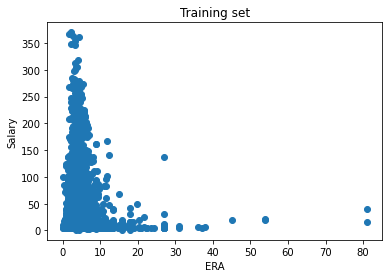

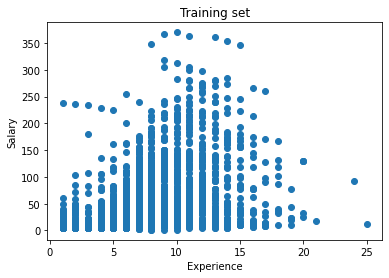

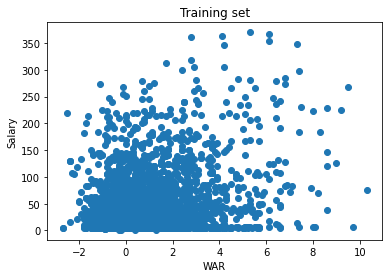

In [223]:
# Visualizations (Initial):

# ERA vs Salary
plt.scatter(filteredData_ERA[:,0], filteredData_ERA[:,1]) 
plt.title("Training set")
plt.xlabel("ERA")
plt.ylabel("Salary")
plt.show()

#Experience vs Salary 
plt.scatter(filteredData_EXP[:,0], filteredData_EXP[:,1]) 
plt.title("Training set")
plt.xlabel("Experience")
plt.ylabel("Salary")
plt.show()

# WAR vs Salary 
plt.scatter(filteredData_WAR[:,0], filteredData_WAR[:,1]) 
plt.title("Training set")
plt.xlabel("WAR")
plt.ylabel("Salary")
plt.show()

In [224]:
##########################################################################################
# Test each training dataset with linear regression

#hyperparamters
learning_rate = 0.0001 #this is alpha in my slide 
initial_b = 0 #this is initial theta_0 
initial_w = 0 #this is initial theta_1
num_iterations = 20 #the number of iterations to adjust

In [225]:
#input: b, w, and loaded traning set (i.e., instances)
#output: return the average of squared error (i.e., cost / (2 * number of instances) as we showed in class)
def compute_cost(b, w, instances):
    # Your code starts here
    #   Please add comments or text cells in between to explain the general idea of each block of the code.
    #   Please feel free to add more cells below this cell if necessary
    numInstances = len(instances)
    i = 0
    sumTotal = 0
    while(i < numInstances):
        squaredError = ((instances[:,0][i]*w + b) - (instances[:,1][i]))**2 # (hyp(x) - y)^2  
        #print(b,w,instances[:,0][i],instances[:,1][i] )
        sumTotal += squaredError 
        i+=1
    return sumTotal / (2 * numInstances)

In [226]:
#input: current b, current w, instances, learning_rate
#output: return updated b and w
def step_gradient(b_current, w_current, instances, learning_rate):
    w_gradient = 0
    b_gradient = 0
    N = float(len(instances))

    #Calculate Gradient
    for i in range(0, len(instances)):
        x = instances[i, 0]
        y = instances[i, 1]
        w_gradient += (1/N) * x * ((w_current*x + b_current) - y)
        b_gradient += (1/N) * 1 * ((w_current*x + b_current) - y)
    
    #Update current w and b
    w_updated = w_current - learning_rate * w_gradient
    b_updated = b_current - learning_rate * b_gradient

    #Return updated parameters
    return b_updated, w_updated


In [227]:
#input: instance, current b, current w, learning rate, and number of iterations
#output: return final b, final w and costs (i.e., a list storing cost in each iteration)
def gradient_descent_runner(instances, current_b, current_w, learning_rate, num_iterations):
    b = current_b
    w = current_w
    cost_list = [] #store cost in each iteration
    
    # Your code starts here
    #   Please add comments or text cells in between to explain the general idea of each block of the code.
    #   Please feel free to add more cells below this cell if necessary
    for i in range(num_iterations):
        cost_list.append(compute_cost(b, w, instances))
        b,w = step_gradient(b, w, instances, learning_rate)
    
    return [b, w, cost_list]

In [247]:
# Find the linear formula (parameters) for each training set:

# WAR vs Salary
b_WAR, w_WAR, cost_list_WAR = gradient_descent_runner(filteredData_WAR, initial_b, initial_w, learning_rate, num_iterations)
print('Optimized b_WAR:', b_WAR)
print('Optimized w_WAR:', w_WAR)
print('Minimized cost:', compute_cost(b_WAR, w_WAR, filteredData_WAR))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# ERA vs Salary
b_ERA, w_ERA, cost_list_ERA = gradient_descent_runner(filteredData_ERA, initial_b, initial_w, learning_rate, num_iterations)
print('Optimized b_ERA:', b_ERA)
print('Optimized w_ERA:', w_ERA)
print('Minimized cost:', compute_cost(b_ERA, w_ERA, filteredData_ERA))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# EXP vs Salary
b_EXP, w_EXP, cost_list_EXP = gradient_descent_runner(filteredData_EXP, initial_b, initial_w, learning_rate, num_iterations)
print('Optimized b_EXP:', b_EXP)
print('Optimized w_EXP:', w_EXP)
print('Minimized cost:', compute_cost(b_EXP, w_EXP, filteredData_EXP))

Optimized b_WAR: 0.07748214603345221
Optimized w_WAR: 0.10743746386395156
Minimized cost: 2109.750322104036
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Optimized b_ERA: 0.07615488705875928
Optimized w_ERA: 0.31921868792048674
Minimized cost: 2065.2742524183504
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Optimized b_EXP: 0.07357227060751799
Optimized w_EXP: 0.6581947391876585
Minimized cost: 1899.581876125893


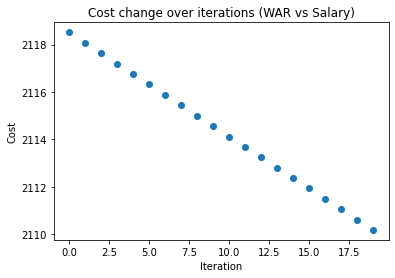

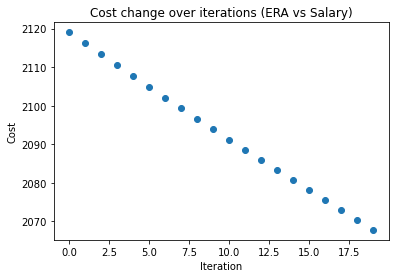

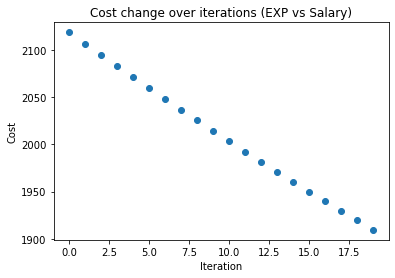

In [267]:
# Compare the change of cost for each data set:
iteration = np.arange(num_iterations)
def showCostChanges(data, title):
    global iteration 
    plt.scatter(iteration, data)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.show()

showCostChanges(cost_list_WAR,"Cost change over iterations (WAR vs Salary)")
showCostChanges(cost_list_ERA,"Cost change over iterations (ERA vs Salary)")
showCostChanges(cost_list_EXP,"Cost change over iterations (EXP vs Salary)")

# The comparisons of cost are quite the same so they
#  don't tell much about the effectiveness of linear regression

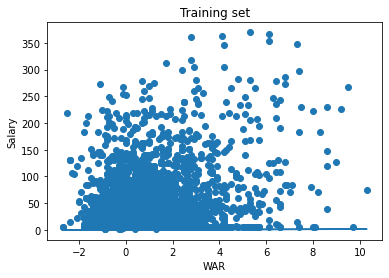

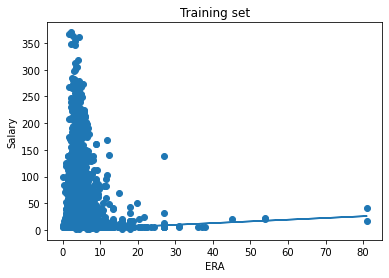

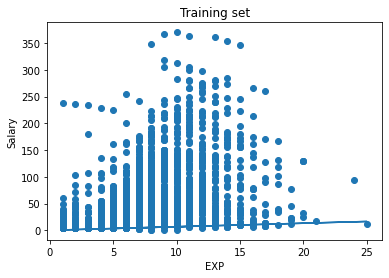

In [249]:
# Visualize line of best fit for each training dataset

def showLinearFit(data, b, w, xlabel, ylabel):
    plt.scatter(data[:,0], data[:,1])
    plt.plot(data[:,0], w*data[:,0]+b)
    plt.title("Training set")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# WAR VS SALARY
showLinearFit(filteredData_WAR, b_WAR, w_WAR, "WAR", "Salary")

# ERA VS SALARY
showLinearFit(filteredData_ERA, b_ERA, w_ERA, "ERA", "Salary")

# EXP VS SALARY
showLinearFit(filteredData_EXP, b_EXP, w_EXP, "EXP", "Salary")

# Insight: 
# The linear regression barely fit all of the data points
#  so linear regression may not be effective enough to predict Salary with each feature

In [257]:
# Testing prediction with linear regression:

# print(np.amax(Salary_test), np.amin(Salary_test))

# Calculate the predicted salary with the parameters
#  given from linear regression
def linearPrediction(test, b, w):
    retVal = [test[i]*w + b
                for i in range(len(test))]
    return retVal

# Create a test set for predicted Salary
def linearTest(prediction, test):
    retTest = []
    for i in range(len(prediction)):
        retTest.append([test[i], prediction[i]])
    retTest = np.array(retTest)
    return retTest
    
# WAR vs Salary
prediction_WAR = linearPrediction(WAR_test, b_WAR, w_WAR)    
testSetWAR = linearTest(prediction_WAR, WAR_test)
print(testSetWAR)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# ERA vs Salary
prediction_ERA = linearPrediction(ERA_test, b_ERA, w_ERA)  
testSetERA = linearTest(prediction_ERA, ERA_test)
print(testSetERA)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# EXP vs Salary
prediction_EXP = linearPrediction(Experience_test, b_EXP, w_EXP)     
testSetEXP = linearTest(prediction_EXP, Experience_test)
print(testSetEXP)


[[ 1.00000000e-01  8.82258924e-02]
 [-7.00000000e-01  2.27592133e-03]
 [ 7.00000000e-01  1.52688371e-01]
 ...
 [ 3.00000000e+00  3.99794538e-01]
 [-7.00000000e-01  2.27592133e-03]
 [-3.00000000e-01  4.52509069e-02]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[[ 4.15        1.40091244]
 [ 8.53        2.7990903 ]
 [27.          8.69505946]
 ...
 [ 1.19        0.45602513]
 [10.8         3.52371672]
 [ 6.91        2.28195602]]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
[[ 9.          5.99732492]
 [ 2.          1.38996175]
 [ 7.          4.68093544]
 ...
 [ 6.          4.02274071]
 [ 1.          0.73176701]
 [11.          7.3137144 ]]


In [263]:
# Visualizing predicted Salary for each feature
def predictedTable(testSet, title):
    pt = PrettyTable(field_names=[title, 'Predicted Salary'])
    [pt.add_row(row) for row in testSet]
    pt.max_width['Text'] = 50
    pt.align= 'l'
    print(pt)

predictedTable(testSetWAR, 'WAR')
predictedTable(testSetERA, 'ERA')
predictedTable(testSetEXP, 'EXP')

# Check if any test set lost any value
# print(len(Experience_test))
# print(len(WAR_test))
# print(len(ERA_test))
# print(len(Salary_test))

# Insights:
# The predicted salary from each feature is off by a lot when comparing to the ground truth within the test set
# The prediction can be less than 10 times comparing to the truth value, so 
#  linear regression is not effective in predicting salary

+------+-----------------------+
| WAR  | Predicted Salary      |
+------+-----------------------+
| 0.1  | 0.08822589241984738   |
| -0.7 | 0.002275921328686134  |
| 0.7  | 0.15268837073821828   |
| -0.2 | 0.0559946532606619    |
| 2.9  | 0.38905079123891173   |
| 2.8  | 0.37830704485251654   |
| 0.4  | 0.12045713157903284   |
| 0.2  | 0.09896963880624253   |
| -0.2 | 0.0559946532606619    |
| -0.3 | 0.04525090687426675   |
| 0.8  | 0.16343211712461347   |
| 2.8  | 0.37830704485251654   |
| 1.7  | 0.26012583460216987   |
| -0.7 | 0.002275921328686134  |
| -0.4 | 0.034507160487871585  |
| -0.9 | -0.019211571444104195 |
| -0.1 | 0.06673839964705705   |
| -0.1 | 0.06673839964705705   |
| 0.9  | 0.1741758635110086    |
| 0.9  | 0.1741758635110086    |
| 1.4  | 0.22789459544298438   |
| 0.2  | 0.09896963880624253   |
| 0.3  | 0.10971338519263768   |
| 1.0  | 0.18491960989740377   |
| 1.0  | 0.18491960989740377   |
| 1.0  | 0.18491960989740377   |
| 0.0  | 0.07748214603345221   |
| -0.4 | 0

In [268]:
##########################################################################################
# Test multidimensional linear regression prediction
# With all the slope(w) and displacement(b) from linear regression, we try to build a regression model to predict salary

# Multidimensional Regression Model
# Follow the formula: y = x1*theta1 + x2*theta2 + x3*theta3 + beta
# Divide the formula by 3 to have equal weight (influence) of each feature on the prediction
def predictBasedOnParameter(ERA, slope_ERA, WAR, slope_WAR, EXP, slope_EXP, ERA_dis, WAR_dis, EXP_dis):
    retVal = (ERA*slope_ERA + WAR*slope_WAR + EXP * slope_EXP+ ERA_dis + WAR_dis + EXP_dis)/3
    return retVal

# Find the difference between the ground truth and predicted Salary
def getDiffSalary(salary, prediction):
    retVal = []
    for i in range(len(salary)):
        retVal.append(salary[i] - prediction[i])
    retVal = np.array(retVal)
    # For displaying the differences
    index = np.arange(len(salary))
    return (retVal,index)

508


508


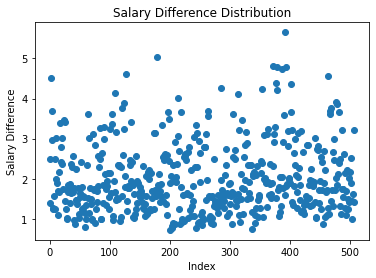

RMSE (Multi Linear):  67.61966235586314


In [271]:
# Calculate the predicted Salary with the multidimensional linear regression
multiPrediction = []
for i in range(len(ERA_test)):
    multiPrediction.append(predictBasedOnParameter(ERA_test[i], w_ERA, WAR_test[i], w_WAR, Experience_test[i], w_EXP
                                                , b_ERA, b_WAR, b_EXP))

# Get the salary difference
multiDiff, index = getDiffSalary(Salary_test, multiPrediction)
# Checking if there is any loss in value after calculating the regression
print(len(multiPrediction))

# Visualizing the salary differences
plt.scatter(index, multiPrediction)
plt.title("Salary Difference Distribution")
plt.xlabel("Index")
plt.ylabel("Salary Difference")
plt.show()

# Find the RMSE of the multidimensional linear regression
print("RMSE (Multi Linear): ",mean_squared_error(Salary_test, multiPrediction, squared=False))


In [264]:
##########################################################################################
# Testing features with exponential regression
def func_exp(x, a, b, c):
        #c = 0
        return a * np.exp(b * x) + c

# Curve fit will try to calculate the the best fit parameters that can apply
#  to the testing regression in order to find predictions
def exponential_regression (x_data, y_data):
    popt, pcov = curve_fit(func_exp, x_data, y_data, p0 = (-1, 0.01, 1))
    print(popt)
    puntos = plt.plot(x_data, y_data, 'x', color='xkcd:maroon', label = "data")
    curva_regresion = plt.plot(x_data, func_exp(x_data, *popt), color='xkcd:teal', label = "fit: {:.3f}, {:.3f}, {:.3f}".format(*popt))
    plt.legend()
    plt.show()
    return popt

[35.24506888  0.17244111 -3.51086933]


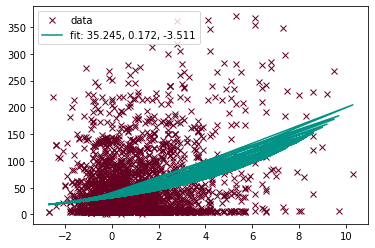

[-1.89165483e+02 -7.05832527e-02  1.64034162e+02]


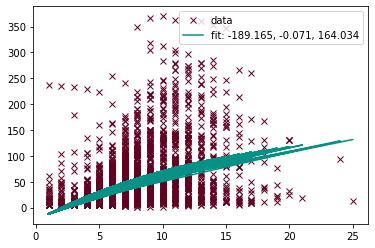

[49.24636531 -0.05778647  0.64272336]


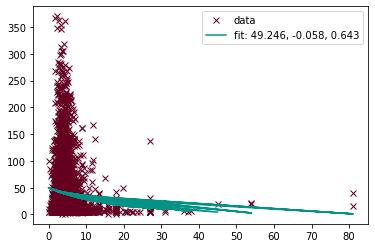

array([49.24636531, -0.05778647,  0.64272336])

In [265]:
# Testing curve fit (exponential regression)
exponential_regression(filteredData_WAR[:,0], filteredData_WAR[:,1])
exponential_regression(filteredData_EXP[:,0], filteredData_EXP[:,1]) 
exponential_regression(filteredData_ERA[:,0], filteredData_ERA[:,1]) 

# Since it will take too long to try every regression on each feature,
#  it is better to predict a regression that are most suitable for a certain feature

In [277]:
##########################################################################################
# For the graph of EXP vs Salary, the distribution closely assemble
#  binomial; therefore, we can try to fit sigmoid derivative regression into that dataset.
# Testing EXP feature with Sigmoid Derivative Regression

# Calculate the prediction base on the formula of sigmoid derivative
def sigmoidDerivative(x, maxC, slopeX, x_disp,y_disp):
    effectiveX = np.exp(-slopeX*(x-x_disp))
    sm = (4*maxC*effectiveX)/((1+effectiveX)**2)
    return sm + y_disp

# Based on the exponential regression, try to find the best fit parameters for
#  Sigmoid Derivative regression
# Have a modification of the number of parameters to control the regression effectively
def sigmoidDerivativeReg(x_data, y_data,p0 = (500, 1, 12.5,100)):
    popt, pcov = curve_fit(sigmoidDerivative, x_data, y_data, p0)
    print(popt)
    puntos = plt.plot(x_data, y_data, 'x', color='xkcd:maroon', label = "data")
    curva_regresion = plt.plot(x_data, sigmoidDerivative(x_data, *popt), color='xkcd:teal', label = "fit: {:.3f}, {:.3f}, {:.3f}".format(*popt))
    plt.xlabel("Experience")
    plt.ylabel("Salary")
    plt.legend()
    plt.show()
    return popt


[110.63272575  -0.29563818  12.60674468 -13.34607922]


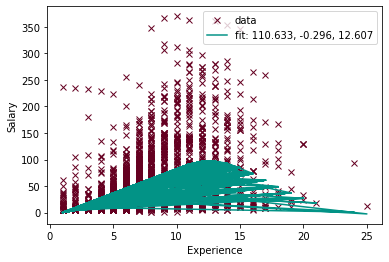

RMSE (Sigmoid Derivative - EXP):  47.01768421108534


In [278]:
# Input: Regression function, input data and best fit parameters (coveriance)
# Output: 1D array of predicted salary
def makePrediction(function, data, coveriancetuple):
    retVal = []
    for i in range(len(data)):
        retVal.append(function(data[i], *coveriancetuple))
    return retVal

# Get the best fit parameters for fitting sigmoid regression into EXP vs Salary
bestFitCoverianceEXP = sigmoidDerivativeReg(filteredData_EXP[:,0], filteredData_EXP[:,1])
# Predicted the salary from the sigmoid regression fit into EXP
predictionEXPS = makePrediction(sigmoidDerivative, Experience_test, bestFitCoverianceEXP)

# Display the Root Mean Squared Error (RMSE) of the differences between the predicted Salary (above)
#  and the ground truth Salary
# The lower the RMSE is, the better the prediction is
print("RMSE (Sigmoid Derivative - EXP): ",mean_squared_error(Salary_test, predictionEXPS , squared=False))

# Insights:
# This is actually the best fit regression for our EXP data. The error score of 47 is unbeatable 
#  until we test the weighted regression much later on. 

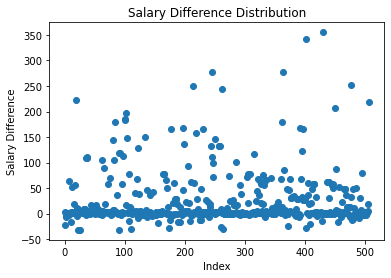

RMSE (Multi Linear + Sigmoid):  58.18986222652572


In [276]:
##########################################################################################
# Since the sigmoid derivative regression is a success for the EXP feature,
#   re-test the multidimensional regression (with sigmoid for EXP), and see if we get any better RMSE

# Update the formula for multidimensional regression
# Can apply other regression formulas directly 
def makeSumPrediction(ERA, ERA_Co,ERA_func, WAR, WAR_Co,WAR_func, EXP, EXP_Co, EXP_func):
    retVal = (ERA_func(ERA, *ERA_Co) + WAR_func(WAR, *WAR_Co) + EXP_func(EXP, *EXP_Co) )/3
    return retVal

# Linear regression formula:
def lerp(data ,b, w):
    retVal = data*w + b
    return retVal

# Calculate the predicted Salary with the modified regression formula:
multPrediction = []
for i in range(len(Salary_test)):
    multPrediction.append(makeSumPrediction(ERA_test[i], (b_ERA, w_ERA), lerp, WAR_test[i], (b_WAR, w_WAR), lerp,
                                            Experience_test[i],bestFitCoverianceEXP, sigmoidDerivative))

# Find and display the new salary differences
diff_Salary2, index = getDiffSalary(Salary_test, multPrediction)
plt.scatter(index, diff_Salary2)
plt.title("Salary Difference Distribution")
plt.xlabel("Index")
plt.ylabel("Salary Difference")
plt.show()

# Check the RMSE for the modified regression formula:
print("RMSE (Multi Linear + Sigmoid): ", mean_squared_error(Salary_test, multPrediction, squared=False))

# Insights:
# The application of Sigmoid derivative regression greatly improve the performance of 
#  multidimensional regression.

[-1.75467255e+03 -6.12600165e-05  3.88374562e+01]


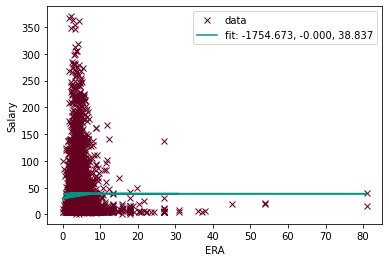

RMSE (Inverse Lerp - ERA):  57.68504668954778


In [279]:
##########################################################################################
# Testing inverse linear regression for ERA feature

# Calculate the predicted salary with inverse linear formula
def InverseLerp(x, slopeX, x_disp, y_disp):
    retVal = 1/(slopeX*(x-x_disp)) + y_disp
    return retVal

# Use curve_fit to find the best fir parameter for this regression.
def inverseReg(x_data, y_data,p0 = (1, 0.3, 0)):
    popt, pcov = curve_fit(InverseLerp, x_data, y_data, p0)
    print(popt)
    puntos = plt.plot(x_data, y_data, 'x', color='xkcd:maroon', label = "data")
    curva_regresion = plt.plot(x_data, InverseLerp(x_data, *popt), color='xkcd:teal', label = "fit: {:.3f}, {:.3f}, {:.3f}".format(*popt))
    plt.xlabel("ERA")
    plt.ylabel("Salary")
    plt.legend()
    plt.show()
    return popt

# Find the best fit parameters and apply that to calculate the predicted Salary
ERA_Co = inverseReg(filteredData_ERA[:,0], filteredData_ERA[:,1])
ERA_predI = [InverseLerp(i,*ERA_Co) for i in ERA_test]

# Checking RMSE for quality testing inverse linear regression
print("RMSE (Inverse Lerp - ERA): ",mean_squared_error(Salary_test, ERA_predI, squared=False))

# Insights:
# Seeing how the line best fit within the graph, inverse linear regression may not be the most effective
#  regression for ERA as of how it barely fit any data points.

[35.24506888  0.17244111 -3.51086933]


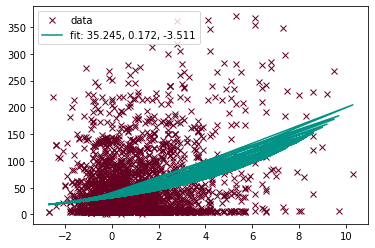

RMSE (Exponential - WAR):  54.61292860409772
RMSE (Linear - WAR):  68.91233779034194
RMSE (Exponential x Sigmoid Derivative - WAR x EXP):  48.40436265835386


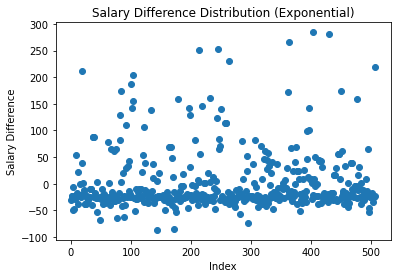

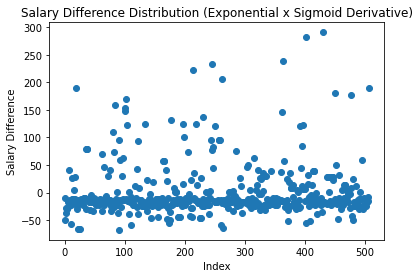

In [282]:
##########################################################################################
# Test if different regressions (for WAR) and sigmoid derivative regression (for EXP)
#  can perform better than the combination of all three features

# Update the predicted regression model that apply the regressions of WAR and EXP
def makeCurvePrediction(WAR, WAR_Co,WAR_func, EXP, EXP_Co, EXP_func):
    retVal = (WAR_func(WAR, *WAR_Co) + EXP_func(EXP, *EXP_Co))/2
    return retVal

# Finding the best fit exponential coveriance for WAR
WAR_Co = exponential_regression(filteredData_WAR[:,0], filteredData_WAR[:,1])
# Predicted the salary with exponential regression for WAR
WAR_prediction = [func_exp(i, *WAR_Co) for i in WAR_test]
# Get the salary differences 
diff_SalarybyWAR, indexWAR = getDiffSalary(Salary_test, WAR_prediction)
# Test the performance of WAR exponential regression 
print("RMSE (Exponential - WAR): ",mean_squared_error(Salary_test, WAR_prediction, squared=False))

# Predicted the salary with linear regression for WAR
WAR_predLinear = [lerp(i, *(b_WAR, w_WAR)) for i in WAR_test]
# Test the performance of WAR linear regression 
print("RMSE (Linear - WAR): ",mean_squared_error(Salary_test, WAR_predLinear, squared=False))

# Predicted the salary using the WAR and EXP regressions model
curvePrediction = []
for i in range(len(Salary_test)):
    curvePrediction.append(makeCurvePrediction(WAR_test[i], WAR_Co, func_exp,
                                               Experience_test[i],bestFitCoverianceEXP, sigmoidDerivative))
# Get the salary differences
diff_SalarybyCurve, indexCurve = getDiffSalary(Salary_test, curvePrediction)
# Test the performance of WAR x EXP regression model
print("RMSE (Exponential x Sigmoid Derivative - WAR x EXP): ",mean_squared_error(Salary_test, curvePrediction, squared=False))

# Compare the salary difference distributions between each regression model.
plt.scatter(indexWAR, diff_SalarybyWAR)
plt.title("Salary Difference Distribution (Exponential)")
plt.xlabel("Index")
plt.ylabel("Salary Difference")
plt.show()

plt.scatter(indexCurve, diff_SalarybyCurve)
plt.title("Salary Difference Distribution (Exponential x Sigmoid Derivative)")
plt.xlabel("Index")
plt.ylabel("Salary Difference")
plt.show()

# Insights:
# The combination of exponetial and sigmoid derivative regression greatly improve the performance
#  compared to the multidimensional regression above.
# It is really close to be better than the sigmoid derivative of EXP

In [284]:
##########################################################################################
# Tets polynomial regression on WAR

WAR_CoPoly = np.polyfit(filteredData_WAR[:,0], filteredData_WAR[:,1], 10)
reverseWAR =  list(reversed(WAR_CoPoly))
WAR_predPoly = polyval(WAR_test,reverseWAR)
print("RMSE (Polynomial - WAR): ",mean_squared_error(Salary_test, WAR_predPoly, squared=False))

# Update the predicted regression model to test polynomial regression 
#   along with sigmoid derivative regression
# We apply heavier weight to which feature contribute more important data for the prediction (EXP in this case)
def makePolyPrediction(WAR, WAR_Co,WAR_func, EXP, EXP_Co, EXP_func, WAR_weight=0.5, EXP_weight=0.5):
    retVal = WAR_func(WAR, WAR_Co)*WAR_weight + EXP_func(EXP, *EXP_Co)*EXP_weight
    return retVal

# Calculate the predicted salary based on the updated model
curvePrediction2 = []
for i in range(len(Salary_test)):
    curvePrediction2.append(makePolyPrediction(WAR_test[i], reverseWAR, polyval,
                                               Experience_test[i],bestFitCoverianceEXP, sigmoidDerivative,
                                              0.3, 0.7))
print("RMSE (Polynomial x Sigmoid Derivative - WAR x EXP): ",mean_squared_error(Salary_test, curvePrediction2, squared=False))


RMSE (Polynomial - WAR):  53.94577973465504
RMSE (Polynomial x Sigmoid Derivative - WAR x EXP):  46.913130862605335


In [286]:
##########################################################################################
# Since the ERA x Salary heavily skewed right, it is recommend to test Gaussian Regression on log(ERA)

# Calculating log(ERA) for both train and test sets
ERA_trainLogU = np.log(filteredData_ERA[:,0])
ERA_testLog = np.log(ERA_test)
# Set invalid inputs of log(ERA) to 0
ERA_trainLog = np.nan_to_num(ERA_trainLogU, posinf=0, neginf=0)

# Debugging for invalid inputs of log(ERA)
# for i in range(len(ERA_trainLogU)):
#     if(ERA_trainLogU[i] != ERA_trainLog[i]):
#         print(ERA_trainLogU[i], ERA_trainLog[i])
# print(np.amax(ERA_trainLog), np.amin(ERA_trainLog))
# print(np.amax(filteredData_ERA[:,1]), np.amin(filteredData_ERA[:,1]))

# Testing with Gaussian Regression causing A LOT of unknown errors so we have to scrap it

# logData_train = [[i,1] for i in ERA_trainLog]
# logData_test = [[i,1] for i in ERA_test]
# gpr = GaussianProcessRegressor(random_state=0).fit(logData_train, filteredData_ERA[:,1])
# Gauss_pred = gpr.predict(logData_test)
# print("Gaussian: ", Gauss_pred)
# print(mean_squared_error(Salary_test, Gauss_pred, squared=False))
# plt.scatter(ERA_test, Gauss_pred)
# plt.scatter(ERA_test, Salary_test)
# plt.show()

# Insights:
# Since how ERA is close to 0, log(0) can generate inputs as NaN or inf but we already fit them out above.

c:\users\huynh\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [244]:
# Since Gaussian Regression is not possible, we test Sigmoid Derivative instead since they are pretty similar

# Test if fixed parameter(s) can provide better prediction
maxValueLog = 0.5
x_dispLog = 1.5
y_dispLog = 0.01
def wrapperSigmoid(x,maxC, slopeX, y_disp):
    global maxValueLog,x_dispLog,y_dispLog
    return sigmoidDerivative(x, maxValueLog, slopeX, x_dispLog,y_dispLog)

# Modify the regression model to test differnet size of parameter input
def sigmoidDerivativeRegLog(x_data, y_data,p0):
    popt, pcov = curve_fit(wrapperSigmoid, x_data, y_data, p0)
    print(popt)
    puntos = plt.plot(x_data, y_data, 'x', color='xkcd:maroon', label = "data")
    curva_regresion = plt.plot(x_data, wrapperSigmoid(x_data, *popt), color='xkcd:teal', label = "fit: {:.3f}, {:.3f}, {:.3f}".format(*popt))
    plt.legend()
    plt.show()
    return popt

[38.38944461  1.30260137  1.01819708  4.92677208]


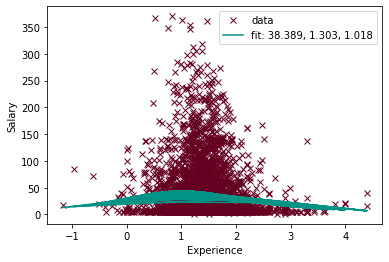

RMSE (Sigmoid Derivative - log(ERA)):  57.342648418627384
[-7.25204042  0.53415005 54.72034538]


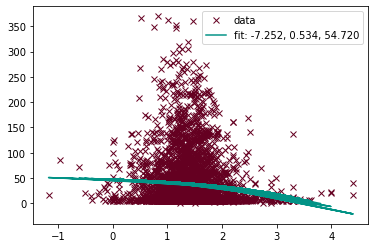

RMSE (Exponential - log(ERA)):  57.423594405028275
RMSE (Sigmoid Derivative x Polynomial - ERA, EXP x WAR) 50.567877462634925


In [287]:
# Test if scaling down Sanity to between 0 and 1, so that the fixed parameter technique may improve the performance
# downScale_salaryTr = [(i-np.amin(filteredData_ERA[:,1])) / (np.amax(filteredData_ERA[:,1]) - np.amin(filteredData_ERA[:,1]))
#                        for i in filteredData_ERA[:,1]]

# offset = np.amin(Salary_test)
# rangeScale = np.amax(Salary_test) - np.amin(Salary_test)
# downScale_salaryTst = [(i-offset) / rangeScale
#                        for i in Salary_test]
# dsError = mean_squared_error(downScale_salaryTst, predictionERALog , squared=False)
# print(dsError*rangeScale + offset)

# Unluckily the modified sigmoid regression didn't improve performance
# Pure implementation is still better
bestFitCoverianceERALog = sigmoidDerivativeReg(ERA_trainLog, filteredData_ERA[:,1],p0 = (50,20,1.5,0))
predictionERALog = makePrediction(sigmoidDerivative, ERA_testLog, bestFitCoverianceERALog)
print("RMSE (Sigmoid Derivative - log(ERA)): ",mean_squared_error(Salary_test, predictionERALog , squared=False))

# Test if exponential regression can perform better than Sigmoid for ERA
ERA_CoLog = exponential_regression(ERA_trainLog, filteredData_ERA[:,1])
ERA_predictionLog = [func_exp(i, *ERA_CoLog) for i in ERA_testLog]
print("RMSE (Exponential - log(ERA)): ",mean_squared_error(Salary_test, ERA_predictionLog , squared=False))

# Test the combination of the best regression of each feature
def makeSumPredictionPoly(ERA, ERA_Co,ERA_func, WAR, WAR_Co,WAR_func, EXP, EXP_Co, EXP_func):
    retVal = (ERA_func(ERA, *ERA_Co) + WAR_func(WAR, WAR_Co)+ EXP_func(EXP, *EXP_Co) )/3
    return retVal
multPredictionFinal = []
for i in range(len(Salary_test)):
    multPredictionFinal.append(makeSumPredictionPoly(ERA_testLog[i], bestFitCoverianceERALog, sigmoidDerivative, 
                                            WAR_test[i], reverseWAR, polyval,
                                            Experience_test[i],bestFitCoverianceEXP, sigmoidDerivative))
print("RMSE (Sigmoid Derivative x Polynomial - ERA, EXP x WAR)",mean_squared_error(Salary_test, multPredictionFinal , squared=False))

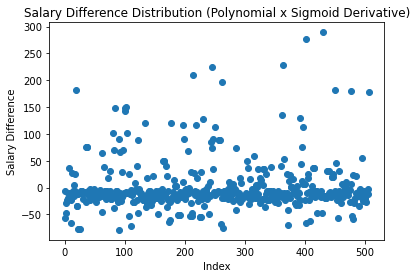

+------+------+--------------------+
| WAR  | EXP  | Predicted Salary   |
+------+------+--------------------+
| 0.1  | 9.0  | 5818525.391047919  |
| -0.7 | 2.0  | 1186646.4041749379 |
| 0.7  | 7.0  | 4224825.219837182  |
| -0.2 | 14.0 | 7311000.813696904  |
| 2.9  | 4.0  | 2909804.8437599153 |
| 2.8  | 3.0  | 2406440.7667777636 |
| 0.4  | 3.0  | 1593502.2134181394 |
| 0.2  | 5.0  | 2609017.2986578024 |
| -0.2 | 8.0  | 4914970.897198496  |
| -0.3 | 3.0  | 1500681.2235592694 |
| 0.8  | 7.0  | 4255360.508739227  |
| 2.8  | 11.0 | 8114403.504524138  |
| 1.7  | 6.0  | 3780141.6796261016 |
| -0.7 | 3.0  | 1565403.2942445162 |
| -0.4 | 2.0  | 1127019.5980125328 |
| -0.9 | 4.0  | 2127182.1422175593 |
| -0.1 | 5.0  | 2566622.468000414  |
| -0.1 | 2.0  | 1128731.1837263831 |
| 0.9  | 8.0  | 5150941.32188674   |
| 0.9  | 10.0 | 6821462.2785790255 |
| 1.4  | 11.0 | 7620999.424095422  |
| 0.2  | 8.0  | 4963344.911568299  |
| 0.3  | 6.0  | 3324655.637975181  |
| 1.0  | 13.0 | 7873439.099598977  |
|

In [291]:
# Conclusion: With all the tests for RMSE, we end up with having the weighted Polynomial x Sigmoid Derivative Regression
#  predict Salary the best

# Visualization for salary difference of the best regression model:
diff_SalaryBest, indexBest = getDiffSalary(Salary_test, curvePrediction2)
plt.scatter(indexBest, diff_SalaryBest)
plt.title("Salary Difference Distribution (Polynomial x Sigmoid Derivative)")
plt.xlabel("Index")
plt.ylabel("Salary Difference")
plt.show()

bestRegressionSet = []
for i in range(len(curvePrediction2)):
    bestRegressionSet.append([WAR_test[i], Experience_test[i], curvePrediction2[i]*(10**5)])
bestRegressionSet = np.array(bestRegressionSet)

pt = PrettyTable(field_names=['WAR', 'EXP', 'Predicted Salary'])
[ pt.add_row(row) for row in bestRegressionSet]
pt.max_width['Text'] = 50
pt.align= 'l'
print(pt)